In [13]:
import mxnet as mx 
from importlib import import_module
import cv2
import matplotlib.pyplot as plt 
import numpy as np 

(100, 3, 28, 28)


128.28692351978179

In [26]:
# 1. data reading
# labels in order: 
"""
0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck
"""

def get_cifar10():
    # TODO fill all the blanks 
    # Hint
    # rgb mean default: '123.68,116.779,103.939',
    # pad size: whatever you think is valid, pad to 32 is good 
    # image shape:  the image shape feed into the network, e.g. (3,224,224)')
    # num-classes: the number of classes
    # num-examples:  the number of training examples, 50000 :)
    # data-nthreads: default=4,number of threads for data decoding, how many cpus do you have
    # dtype: default is float32, can be data type: float32 or float16')
    train = mx.io.ImageRecordIter(
            path_imgrec         = "../cifar10/data/cifar10_train.rec",
            label_width         = 1,
            mean_r              = 123.68,
            mean_g              = 116.779,
            mean_b              = 103.939,
            data_name           = 'data',
            label_name          = 'softmax_label',
            data_shape          = (3,28,28),
            batch_size          = 128,
            pad                 = 0,
            fill_value          = 127,
            preprocess_threads  = 4,
            shuffle             = True)
    val = mx.io.ImageRecordIter(
            path_imgrec         = "../cifar10/data/cifar10_val.rec",
            label_width         = 1,
            mean_r              = 123.68,
            mean_g              = 116.779,
            mean_b              = 103.939,
            data_name           = 'data',
            label_name          = 'softmax_label',
            data_shape          = (3,28,28),
            batch_size          = 128,
            pad                 = 0,
            fill_value          = 127,
            preprocess_threads  = 4,
            shuffle             = False)
    return train, val

train, val = get_cifar10()
# TODO write the script to look what is inside train and val
# Check the image size, and label 
# Question? check MXNET_course/mxnet-week3/cifar10/step_by_step_debug.ipynb
print (train, val)
for i in range(3):
    batch = train.next()
    print batch 

# img1 = batch.data[0].asnumpy()[0,:,:,:].transpose((1,2,0))
# print img1.shape
# print np.max(img1), np.min(img1)

(<mxnet.io.MXDataIter object at 0x7f2b35d5ee90>, <mxnet.io.MXDataIter object at 0x7f2b35d5eed0>)
DataBatch: data shapes: [(128L, 3L, 28L, 28L)] label shapes: [(128L,)]
DataBatch: data shapes: [(128L, 3L, 28L, 28L)] label shapes: [(128L,)]
DataBatch: data shapes: [(128L, 3L, 28L, 28L)] label shapes: [(128L,)]


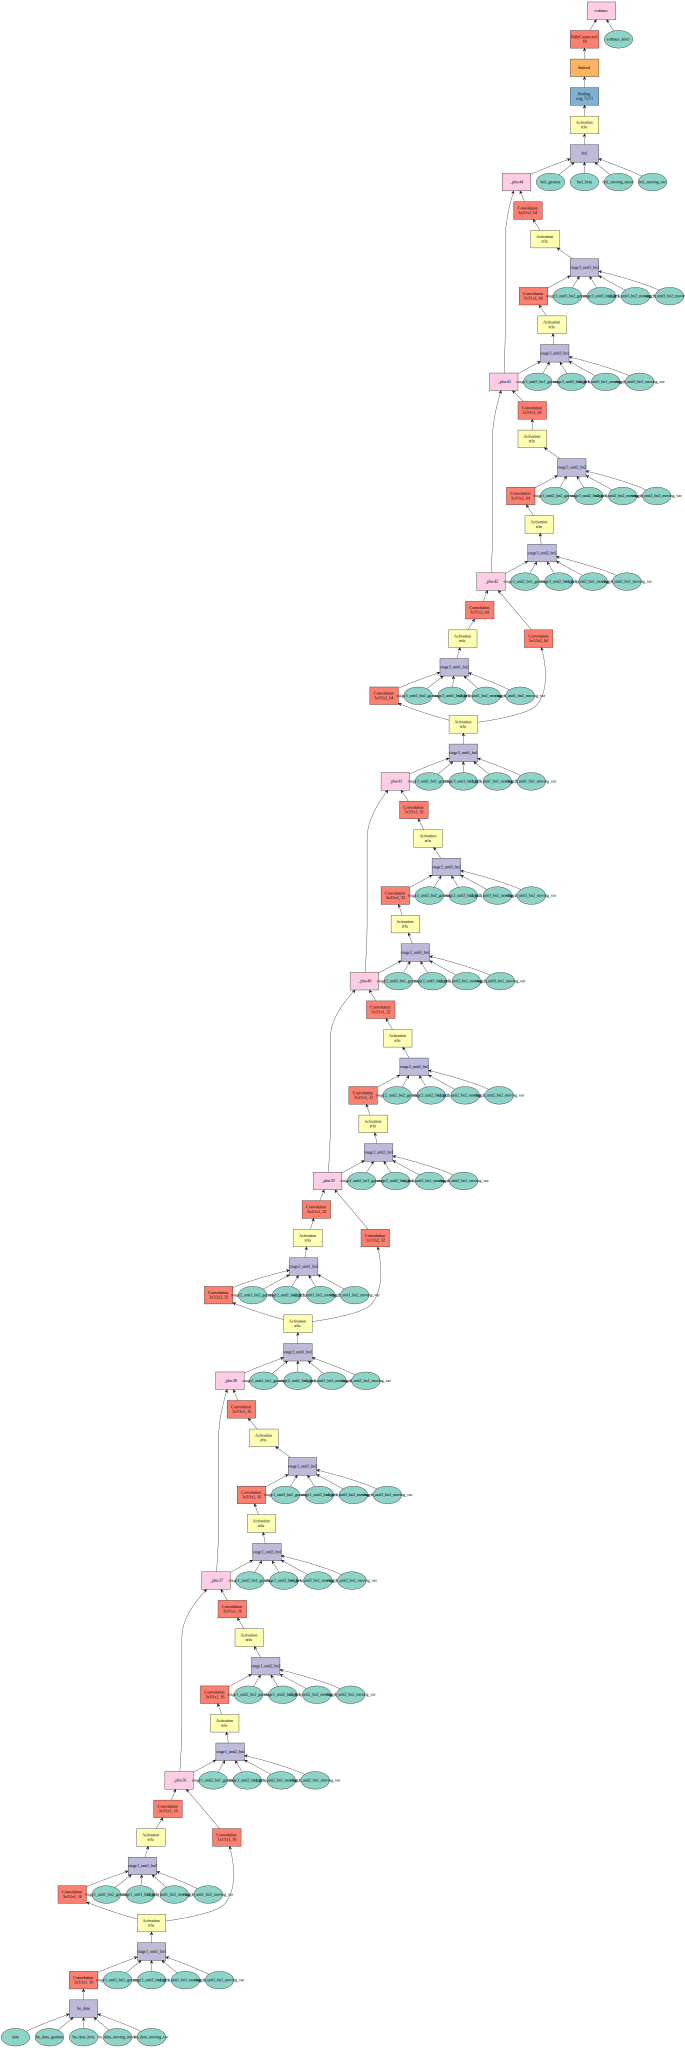

In [30]:
# 2 model getting 
# TODO read through resnet.py file for understanding
def get_resnet():
    net = import_module('resnet')
    sym = net.get_symbol(10,20,"3,28,28")
    return sym 
sym = get_resnet()

# TODO 
# 1. Plot and visualize the network. Put your comments about its architecture (why bottlenet)
# 2. List all weight and output (Question? check MXNET_course/mxnet-week3/cifar10/step_by_step_debug.ipynb)
mx.viz.plot_network(sym)
# print sym.get_internals()
# print sym.list_arguments()
# print sym.list_auxiliary_states()

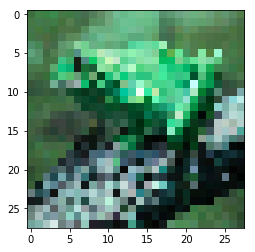

<type 'numpy.ndarray'>
(1, 3, 28, 28)


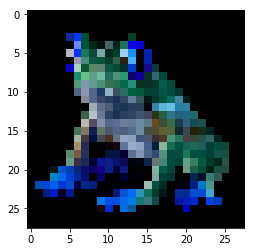

<type 'numpy.ndarray'>
(1, 3, 28, 28)
The very small training dataset contain:  (2, 3, 28, 28)
small dataset is:  <class 'mxnet.io.NDArrayIter'>
DataBatch: data shapes: [(1L, 3L, 28L, 28L)] label shapes: [(1L,)]
DataBatch: data shapes: [(1L, 3L, 28L, 28L)] label shapes: [(1L,)]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [4]:
# 3 sanity check random image inference
img1 = cv2.imread("frog.jpg")
img1 = cv2.resize(img1,(28,28))# you need to pad it if you do padding for you nework
plt.imshow(img1)
plt.show()
print type(img1)
img1 = img1.transpose((2,0,1)).reshape((1,3,28,28))
print img1.shape

img2 = cv2.imread("frog2.jpg")
img2 = cv2.resize(img2,(28,28))# you need to pad it if you do padding for you nework
plt.imshow(img2)
plt.show()
print type(img2)
img2 = img2.transpose((2,0,1)).reshape((1,3,28,28))
print img2.shape

img = np.vstack([img1,img2])
print "The very small training dataset contain: ", img.shape

# TODO: figure out how to convert numpy array to mx.nd.array
img_mxnd = mx.nd.array(ctx=mx.cpu(), source_array=img) # ???
label_mxnd = mx.nd.array(ctx=mx.cpu(), source_array=np.asarray([6,6])) # 6 is frog
img_itr = mx.io.NDArrayIter(data=img_mxnd, data_name='data', 
                            label_name='softmax_label', label=label_mxnd, 
                            batch_size=1) # ??? Hint the name should "data" and softmax_label
print "small dataset is: ", type(img_itr)
for each in img_itr:
    print each

# TODO bind the random img to network 
# question? check mxnet-week3/cifar10/train_cifar10.py
mod = mx.mod.Module(sym, context=mx.gpu(0)) # ???
mod.bind(img_itr.provide_data,img_itr.provide_label)
mod.init_params(mx.init.Xavier(rnd_type='gaussian', factor_type='in',magnitude=2)) 

# run forward perdiction 
# TODO fill the mod.predict 
# check mod.predict
out = mod.predict(eval_data=img_itr,num_batch=2,reset=True)
print out.asnumpy()

In [5]:
print np.argmax(out.asnumpy(),axis=1)

[9 9]


In [6]:
# 4 overfit small dataset 
# TODO fill all ???
mod.init_params(mx.init.Xavier(rnd_type='gaussian', factor_type='in',magnitude=2)) # ???
mod.init_optimizer(optimizer='rmsprop') 
# run forward perdiction
metric = mx.metric.create('acc')

for epoch in range(5):
    img_itr.reset()
    metric.reset()
    for batch in img_itr:
        mod.forward(batch, is_train=True)
        mod.update_metric(metric, batch.label)
        mod.backward()
        mod.update()
    print ('Epoch {}, Train {}'.format(epoch, metric.get()))
    # You should get 100% accuacy on these two images


Epoch 0, Train ('accuracy', 0.5)
Epoch 1, Train ('accuracy', 1.0)
Epoch 2, Train ('accuracy', 1.0)
Epoch 3, Train ('accuracy', 1.0)
Epoch 4, Train ('accuracy', 1.0)


/home/chuck/DLenv/MXNet/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
#5 (optional) train cifar10 on resnet(~epoch) if you have GPU. Build the training script from week2
mod_cifar = mx.mod.Module(sym, context=mx.gpu(0)) # ???
train.reset()
val.reset()
mod_cifar.fit(train_data=train,
              eval_data=val,
              num_epoch=10,
              optimizer='rmsprop', 
              optimizer_params={'learning_rate':0.1}, 
              epoch_end_callback=mx.callback.do_checkpoint('resnet_cifar_10'),
              initializer=mx.init.Xavier(rnd_type='gaussian', factor_type='in',magnitude=2),
              batch_end_callback=[mx.callback.Speedometer(128, 1)], 
              eval_metric=['acc','ce'])

In [8]:
# 6 (optional) Wild test on your model 